# py0xcluster

py0xCluster is a package dedicated to perform exploratory data analysis and machine learning tasks on DEX activity (Decentralized Exhanges) and web3 data.

This is for now an educational project for myself with the aim of performing fun data-science projects around blockchain data gathered through the Graph Network (https://thegraph.com/)

## Target objectives

- Establish meaningful grouping of address by clustering DEX traders and LP
    - Feature Extraction:
        - TBD but based on mint/swap/burn data from messari subgraphs entities
        - with or without balances at swap time (web3py fetch balance at block)
        - EOA vs Contracts
    - Dimensionality reduction:
        - UMAP / tSNE or PCA / ICA
    - Clustering:
        - DBSCAN
        - silhouette evaluation
    - Visualization:
        - scatter plot with color-coded returns? (TBD)

## Secondary objective: identify which group has the most profitable activity

- Triggered Average of price by swap in/out by group of addresses

- Predict future returns based on the activity of previously clustered groups of addresses

## ML overall approach:

- Decide whether adopting time-series vs tabular approach (preference for the first one)
- Compute time-series based on extracted features and certain kernels / windowing
- Begin by classification approach of expected future (down-bad / neurtral / up-strong)
- Extend to regression

## Random list of potential features:

### Accounts

### Relative to a pool:
- z-scored (clarify how) difference of price 24h? after swap -> could be target independant variable

- nb of events (z-scored to other addresses on same pool)
- average swap size (z-scored/pool)
- average deposit size (z-scored/pool)
- average withdraw size (z-score/pool)

### Account only

- Total nb of positions: swapCount, depositCount, withdrawCount
- ratio? of nb of: swaps / (deposits + withdraws)

### Account - Position
- nb of (liquid) pools interacted with
- % of events (likely swaps) happening in the same block (possibly identical to MEV bots?)
- % of Limit order on uni-v3 (one deposit amout = 0)

### Account - Web3

- is contract?
- Normalized balance (compared to other users) at time of events

# Roadmap:

## Easy / To implement first

### Aggregation / Feature computation

- Aggregate unique addresses
- Implement Account-only query
- First Web3 requests (is_contract / ETH balance)

### First plots

- First features distribution
- PCA/ICA -> t-SNE

## Next, not immediate priority

- Pool clustering / identify easy-best features

### Data Management

- Store/Retrieve to/from SQLite?
- Consider parquet / feather / hdf5

## Secondary, nice to do

### Package

- Update and test requirements / setup
- Document classes and methods with nicely formatted docstrings to future build of the doc

### Performance

- Evaluate performance, profiling, and try improving inefficient / slow bits

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns

from py0xcluster.utils.web3_utils import *
from py0xcluster.utils.query_utils import *
from py0xcluster.main_classes.pools import *
from py0xcluster.main_classes.pool_events import *

from py0xcluster.features.swaps_feature_extractors import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Gathering data about most-active pools

In [16]:
uni3pools_selector = PoolSelector(
    subgraph_url = 'https://api.thegraph.com/subgraphs/name/messari/uniswap-v3-ethereum',
    min_daily_volume_USD = 500000,
    min_TVL = 500000, # Not implemented. consider removing
    start_date = (2022,12,31), 
    end_date = (2023,3,14),
    days_batch_size = 20)

uni3_pools = uni3pools_selector.create_pool_selection(stables='exclude', verbose=True)
uni3_pools.pools_df.head(5)

Queriying from 2022-12-31 00:00:00 to 2023-01-20 00:00:00
Queriying from 2023-01-20 00:00:00 to 2023-02-09 00:00:00
Queriying from 2023-02-09 00:00:00 to 2023-03-01 00:00:00
Queriying from 2023-03-01 00:00:00 to 2023-03-14 00:00:00
8578 lquidity pools snapshots retrieved
1430 stable pools snapshots (over 8578) have been removed
1177 illiquid pools snapshots (over 7148) have been removed 
119 pools were selected


,pool.name,dailyTotalVolumeUSD,pool.totalValueLockedUSD,token0.lastPriceUSD,token1.lastPriceUSD,pool.protocol.name,pool.protocol.network,pool.id,token0.symbol,token0.decimals,token1.symbol,token1.decimals
0,Uniswap V3 USD Coin/Wrapped Ether 0.05%,3.834651e+08,1.865302e+08,1.000000,1707.74744,Uniswap V3,MAINNET,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC,6,WETH,18
1,Uniswap V3 USD Coin/Wrapped Ether 0.01%,9.441846e+07,6.104614e+05,1.000000,1707.74744,Uniswap V3,MAINNET,0xe0554a476a092703abdb3ef35c80e0d76d32939f,USDC,6,WETH,18
2,Uniswap V3 Wrapped BTC/Wrapped Ether 0.05%,4.338668e+07,1.277986e+08,24705.168293,1707.74744,Uniswap V3,MAINNET,0x4585fe77225b41b697c938b018e2ac67ac5a20c0,WBTC,8,WETH,18
3,Uniswap V3 Wrapped Ether/Tether USD 0.05%,4.045229e+07,4.474962e+07,1707.747440,1.00000,Uniswap V3,MAINNET,0x11b815efb8f581194ae79006d24e0d814b7697f6,WETH,18,USDT,6
4,Uniswap V3 USD Coin/Wrapped Ether 0.3%,2.153225e+07,1.200513e+08,1.000000,1707.74744,Uniswap V3,MAINNET,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC,6,WETH,18


## Extracting all events from these pools

### Steps

- Data query:
    - Perform query for each pool, batch by days to accomodate response limit
    - Alternatively the query can be done on multiple pools. Ideally, the size of the batch should be proportional to the volume, but quite arbitrary to implement.
    - Consider whether do swaps / mints / burns separately or jointly
    - Loop and aggregate over days / pools (or batch of pools)


In [3]:
uni3_pools.pools_df.head(3)

,pool.name,dailyVolumeUSD,pool.totalValueLockedUSD,token0.lastPriceUSD,token1.lastPriceUSD,pool.protocol.name,pool.protocol.network,pool.id,token0.symbol,token0.decimals,token1.symbol,token1.decimals
0,Uniswap V3 USD Coin/Wrapped Ether 0.05%,2.131306e+08,1.696759e+08,1.000000,1603.295437,Uniswap V3,MAINNET,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC,6,WETH,18
1,Uniswap V3 USD Coin/Wrapped Ether 0.01%,4.207116e+07,2.431602e+07,1.000000,1603.295437,Uniswap V3,MAINNET,0xe0554a476a092703abdb3ef35c80e0d76d32939f,USDC,6,WETH,18
2,Uniswap V3 Wrapped Ether/Tether USD 0.05%,3.227337e+07,2.449635e+07,1603.295437,1.000000,Uniswap V3,MAINNET,0x11b815efb8f581194ae79006d24e0d814b7697f6,WETH,18,USDT,6


In [36]:
uni3_pools.pools_df['pool.id'].values

<StringArray>
['0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640',
 '0xe0554a476a092703abdb3ef35c80e0d76d32939f',
 '0x4585fe77225b41b697c938b018e2ac67ac5a20c0',
 '0x11b815efb8f581194ae79006d24e0d814b7697f6',
 '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8',
 '0xa3f558aebaecaf0e11ca4b2199cc5ed341edfd74',
 '0x824a30f2984f9013f2c8d0a29c0a3cc5fd5c0673',
 '0xcbcdf9626bc03e24f779434178a73a0b4bad62ed',
 '0x4e68ccd3e89f51c3074ca5072bbac773960dfa36',
 '0x60594a405d53811d3bc4766596efd80fd545a270',
 ...
 '0x59c38b6775ded821f010dbd30ecabdcf84e04756',
 '0x498498fa386ef2860e7abf8c60254580c8c41ec5',
 '0x8f0350c8be74b4cb0458cbf04d16753000fda9d0',
 '0xc72abb13b6bdfa64770cb5b1f57bebd36a91a29e',
 '0x6ae0cdc5d2b89a8dcb99ad6b3435b3e7f7290077',
 '0xe859041c9c6d70177f83de991b9d757e13cea26e',
 '0x33e71cacbb6b596bc006aac3eeaa2817e8212264',
 '0x3688ec45e6c03e78954f96a17d3dc4d7c4794ca4',
 '0x1a89ae3ba4f9a97b10bac6a77061f00bb956858b',
 '0x3012e36cc30eb7ed916b8d4b82750b39551874dc']
Length: 119, dtype: string

In [91]:
uni3_events_getter = PoolEventGetter(
    subgraph_url = 'https://api.thegraph.com/subgraphs/name/messari/uniswap-v3-ethereum',
    pools_data = uni3_pools,
    pool_ids = uni3_pools.pools_df['pool.id'].values[0],
    start_date = (2023,1,14), 
    end_date = (2023,1,15),
    days_batch_size = 1
    )

# Get swaps, deposits, and withdraw from a pool.
uni3_events = uni3_events_getter.get_events(verbose=True)


pool nb 0/1: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
Queriying from 2023-01-14 00:00:00 to 2023-01-15 00:00:00
variables:
{'pool_id': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', 'start_date': 1673654400, 'end_date': 1673740800, 'first': 1000, 'skip': 6000}


In [86]:
uni3_pools.pools_df

,pool.name,dailyTotalVolumeUSD,pool.totalValueLockedUSD,token0.lastPriceUSD,token1.lastPriceUSD,pool.protocol.name,pool.protocol.network,pool.id,token0.symbol,token0.decimals,token1.symbol,token1.decimals
0,Uniswap V3 USD Coin/Wrapped Ether 0.05%,3.834651e+08,1.865302e+08,1.000000,1707.74744,Uniswap V3,MAINNET,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC,6,WETH,18
1,Uniswap V3 USD Coin/Wrapped Ether 0.01%,9.441846e+07,6.104614e+05,1.000000,1707.74744,Uniswap V3,MAINNET,0xe0554a476a092703abdb3ef35c80e0d76d32939f,USDC,6,WETH,18
2,Uniswap V3 Wrapped BTC/Wrapped Ether 0.05%,4.338668e+07,1.277986e+08,24705.168293,1707.74744,Uniswap V3,MAINNET,0x4585fe77225b41b697c938b018e2ac67ac5a20c0,WBTC,8,WETH,18
3,Uniswap V3 Wrapped Ether/Tether USD 0.05%,4.045229e+07,4.474962e+07,1707.747440,1.00000,Uniswap V3,MAINNET,0x11b815efb8f581194ae79006d24e0d814b7697f6,WETH,18,USDT,6
4,Uniswap V3 USD Coin/Wrapped Ether 0.3%,2.153225e+07,1.200513e+08,1.000000,1707.74744,Uniswap V3,MAINNET,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC,6,WETH,18
...,...,...,...,...,...,...,...,...,...,...,...,...
114,Uniswap V3 Hedron/USD Coin 1%,6.205268e+05,1.094342e+06,0.000002,1.00000,Uniswap V3,MAINNET,0xe859041c9c6d70177f83de991b9d757e13cea26e,HDRN,9,USDC,6
115,Uniswap V3 Lido DAO Token/USD Coin 0.3%,6.188717e+05,9.746437e+05,2.779566,1.00000,Uniswap V3,MAINNET,0x33e71cacbb6b596bc006aac3eeaa2817e8212264,LDO,18,USDC,6
116,Uniswap V3 UniDex/Wrapped Ether 1%,5.825677e+05,1.476107e+06,6.955757,1707.74744,Uniswap V3,MAINNET,0x3688ec45e6c03e78954f96a17d3dc4d7c4794ca4,UNIDX,18,WETH,18
117,Uniswap V3 IMPT/Wrapped Ether 0.3%,5.322040e+05,1.260639e+06,0.008034,1707.74744,Uniswap V3,MAINNET,0x1a89ae3ba4f9a97b10bac6a77061f00bb956858b,IMPT,18,WETH,18


In [93]:
uni3_events.deposits

,amountUSD,timestamp,blockNumber,id,account.id,InputTokenAmount0,InputTokenAmount1,pool.id
0,4.131452e+07,2023-01-14 04:35:47,16402690,0x006d9b529f190fff559be0bac927fc9a4e8f3c767e19...,0x479bc00624e58398f4cf59d78884d12fb515790a,1.308786e+07,1.815693e+16,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
1,2.369681e+04,2023-01-14 00:36:23,16401498,0x00ba663bb55884f5d9780f98231afa6dd1e85458aa61...,0x584c08a5e6dfbb71346e3cda140e133c2890fd7a,2.357475e+04,8.263323e+10,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
2,3.624551e+07,2023-01-14 00:21:23,16401423,0x012875e0b701d0d82295797075131a9f2468395efa35...,0xfb9779477e5b4834bf2bc02dd29b97b344d0f700,2.602169e+07,6.985271e+15,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
3,2.974599e+02,2023-01-14 23:33:35,16408355,0x013cbd0270bbf7964b2090a0e413f5ac040c04f25c77...,0x939e0f3a0a4a9c2cd0be350db247a1b20a016191,1.328873e+02,1.061756e+11,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
4,1.028696e+04,2023-01-14 04:15:47,16402591,0x0155f0a0036188f1213e1a9438029f04f49a8ebe11fd...,0x81d8508d919e268ac1b91bd0ec12d1db10af966f,1.015752e+04,8.332980e+10,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
...,...,...,...,...,...,...,...,...
939,3.735172e+05,2023-01-14 00:59:11,16401612,0xfdad80ebf43c3ad69ba67dcd5f31daf5e246dea9ec7d...,0x36e5a96c8d01803d2c48756aa7bde1c01d7d9f8a,3.734304e+05,5.629030e+10,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
940,1.016189e+06,2023-01-14 20:21:59,16407404,0xfe355574d1e1d98b4fe4daba9d6d9e5d993689a28614...,0xcf58eac3c7d16796aea617a7e2461c99cacdff1d,1.016187e+06,1.468536e+09,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
941,9.941149e+06,2023-01-14 01:59:59,16401912,0xfee4aa81e9a13e1f38e51020faa0bf77e438abd083e0...,0x0039b625b1d8632c7a0057c964ec58a9f39789d3,4.990917e+06,3.197302e+15,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
942,4.343547e+05,2023-01-14 07:06:59,16403443,0xff2e4b13f771f818134a17014a920633c05734f269c9...,0xfe293b421756739abfdd4ea489b27c337baaa11c,4.343547e+05,0.000000e+00,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640


In [71]:
non_unique_swaps_index = uni3_events.swaps.groupby(['pool.id','account.id']).count().id != 0
non_unique_swaps_index.index

MultiIndex([('0x1a89ae3ba4f9a97b10bac6a77061f00bb956858b', ...),
            ('0x1a89ae3ba4f9a97b10bac6a77061f00bb956858b', ...),
            ('0x1a89ae3ba4f9a97b10bac6a77061f00bb956858b', ...),
            ('0x1a89ae3ba4f9a97b10bac6a77061f00bb956858b', ...),
            ('0x1a89ae3ba4f9a97b10bac6a77061f00bb956858b', ...),
            ('0x1a89ae3ba4f9a97b10bac6a77061f00bb956858b', ...),
            ('0x1a89ae3ba4f9a97b10bac6a77061f00bb956858b', ...),
            ('0x1a89ae3ba4f9a97b10bac6a77061f00bb956858b', ...),
            ('0x1a89ae3ba4f9a97b10bac6a77061f00bb956858b', ...),
            ('0x1a89ae3ba4f9a97b10bac6a77061f00bb956858b', ...),
            ...
            ('0xe859041c9c6d70177f83de991b9d757e13cea26e', ...),
            ('0xe859041c9c6d70177f83de991b9d757e13cea26e', ...),
            ('0xe859041c9c6d70177f83de991b9d757e13cea26e', ...),
            ('0xe859041c9c6d70177f83de991b9d757e13cea26e', ...),
            ('0xe859041c9c6d70177f83de991b9d757e13cea26e', ...),
         

## Computation of features and aggregation by account.id

In [54]:
# Features from swaps

uni3_events.swaps = compute_slippage(uni3_events.swaps)

uni3_events.swaps = uni3_events.swaps.round(2)

uni3_events.swaps = compute_zscore(
    uni3_events.swaps, 
    columns= ['amountInUSD', 'amountOutUSD', 'slippage'],
    group_by= 'pool.id')

# uni3_events.swaps = same_from_to(uni3_events.swaps, to_float=True)

addresses_swaps_features = aggregate_features(uni3_events.swaps, methods = ['median','mean','min','max','count'],
    columns = ['amountInUSD.zscore', 'slippage.zscore'],
    group_by = 'account.id')

# Tidy up useless columns            
addresses_swaps_features.drop(
    columns=['slippage.zscore.count', 'amountInUSD.zscore.count'], inplace=True)

addresses_swaps_features.rename(columns={'account.id':'tx.count'},inplace=True)


# Features from deposits
uni3_events.deposits = compute_zscore(
    uni3_events.deposits, 
    columns=['amountUSD', 'InputTokenAmount0', 'InputTokenAmount1'], 
    group_by= 'pool.id')

# uni3_events.deposits = same_from_to(uni3_events.deposits, to_float=True)

uni3_events.deposits = find_limit_orders(uni3_events.deposits)

addresses_deposits_features = aggregate_features(uni3_events.deposits, 
    methods = ['median','mean','min','max','count'],
    columns = ['amountUSD.zscore', 'is_limit_order'],
    group_by = 'account.id')

# Tidy up useless columns            
addresses_deposits_features.drop(
    columns=['is_limit_order.min', 'is_limit_order.max',
    'is_limit_order.median', 'is_limit_order.count', 'amountUSD.zscore.count'], inplace=True)

addresses_deposits_features.rename(columns={'account.id':'tx.count'},inplace=True)

# Features from withdraws
uni3_events.withdraws = compute_zscore(
    uni3_events.withdraws, 
    columns=['amountUSD', 'InputTokenAmount0', 'InputTokenAmount1'], 
    group_by= 'pool.id')

# uni3_events.withdraws = same_from_to(uni3_events.withdraws, to_float=True)

addresses_withdraws_features = aggregate_features(uni3_events.withdraws, methods = ['median','mean','min','max','count'],
    columns = ['amountUSD.zscore', ],
            group_by = 'account.id')

# Tidy up useless columns            
addresses_withdraws_features.drop(
    columns=['amountUSD.zscore.count'], inplace=True)

addresses_withdraws_features.rename(columns={'account.id':'tx.count'},inplace=True)


In [55]:
addresses_swaps_features

,amountInUSD.zscore.median,slippage.zscore.median,amountInUSD.zscore.mean,slippage.zscore.mean,amountInUSD.zscore.min,slippage.zscore.min,amountInUSD.zscore.max,slippage.zscore.max
account.id,,,,,,,,
0x00000006e42915a2b6907f8b3faf311b68862f60,-0.459593,NaN,-0.459593,NaN,-0.459593,NaN,-0.459593,NaN
0x002d482f5308a51d3553bd2b6c79fbf9283137c6,-0.304133,NaN,-0.304133,NaN,-0.304133,NaN,-0.304133,NaN
0x00356ce6250f8489d23ff32742256ab5be9dd8d7,-0.325144,NaN,-0.325144,NaN,-0.325144,NaN,-0.325144,NaN
0x0037825fd75af7eeace28889665e3fac8fdb6300,-0.222274,NaN,-0.222274,NaN,-0.325144,NaN,-0.119404,NaN
0x00b7dc1f772dec63863a82064b1d1c5f5af243b9,-0.058325,0.025096,-0.058325,0.025096,-0.058325,0.025096,-0.058325,0.025096
...,...,...,...,...,...,...,...,...
0xfed9f8cb3c55618f513e2bb717a01452cad2d146,-0.294182,NaN,-0.294182,NaN,-0.325144,NaN,-0.263219,NaN
0xff57ae5870529b80ea01d403c3f8bd94d11b9678,0.356535,NaN,0.356535,NaN,0.338968,NaN,0.374103,NaN
0xff69f78d2b52ba98fd51f026265a035d183ad577,-0.180388,-0.068407,-0.180388,-0.068407,-0.180388,-0.068407,-0.180388,-0.068407


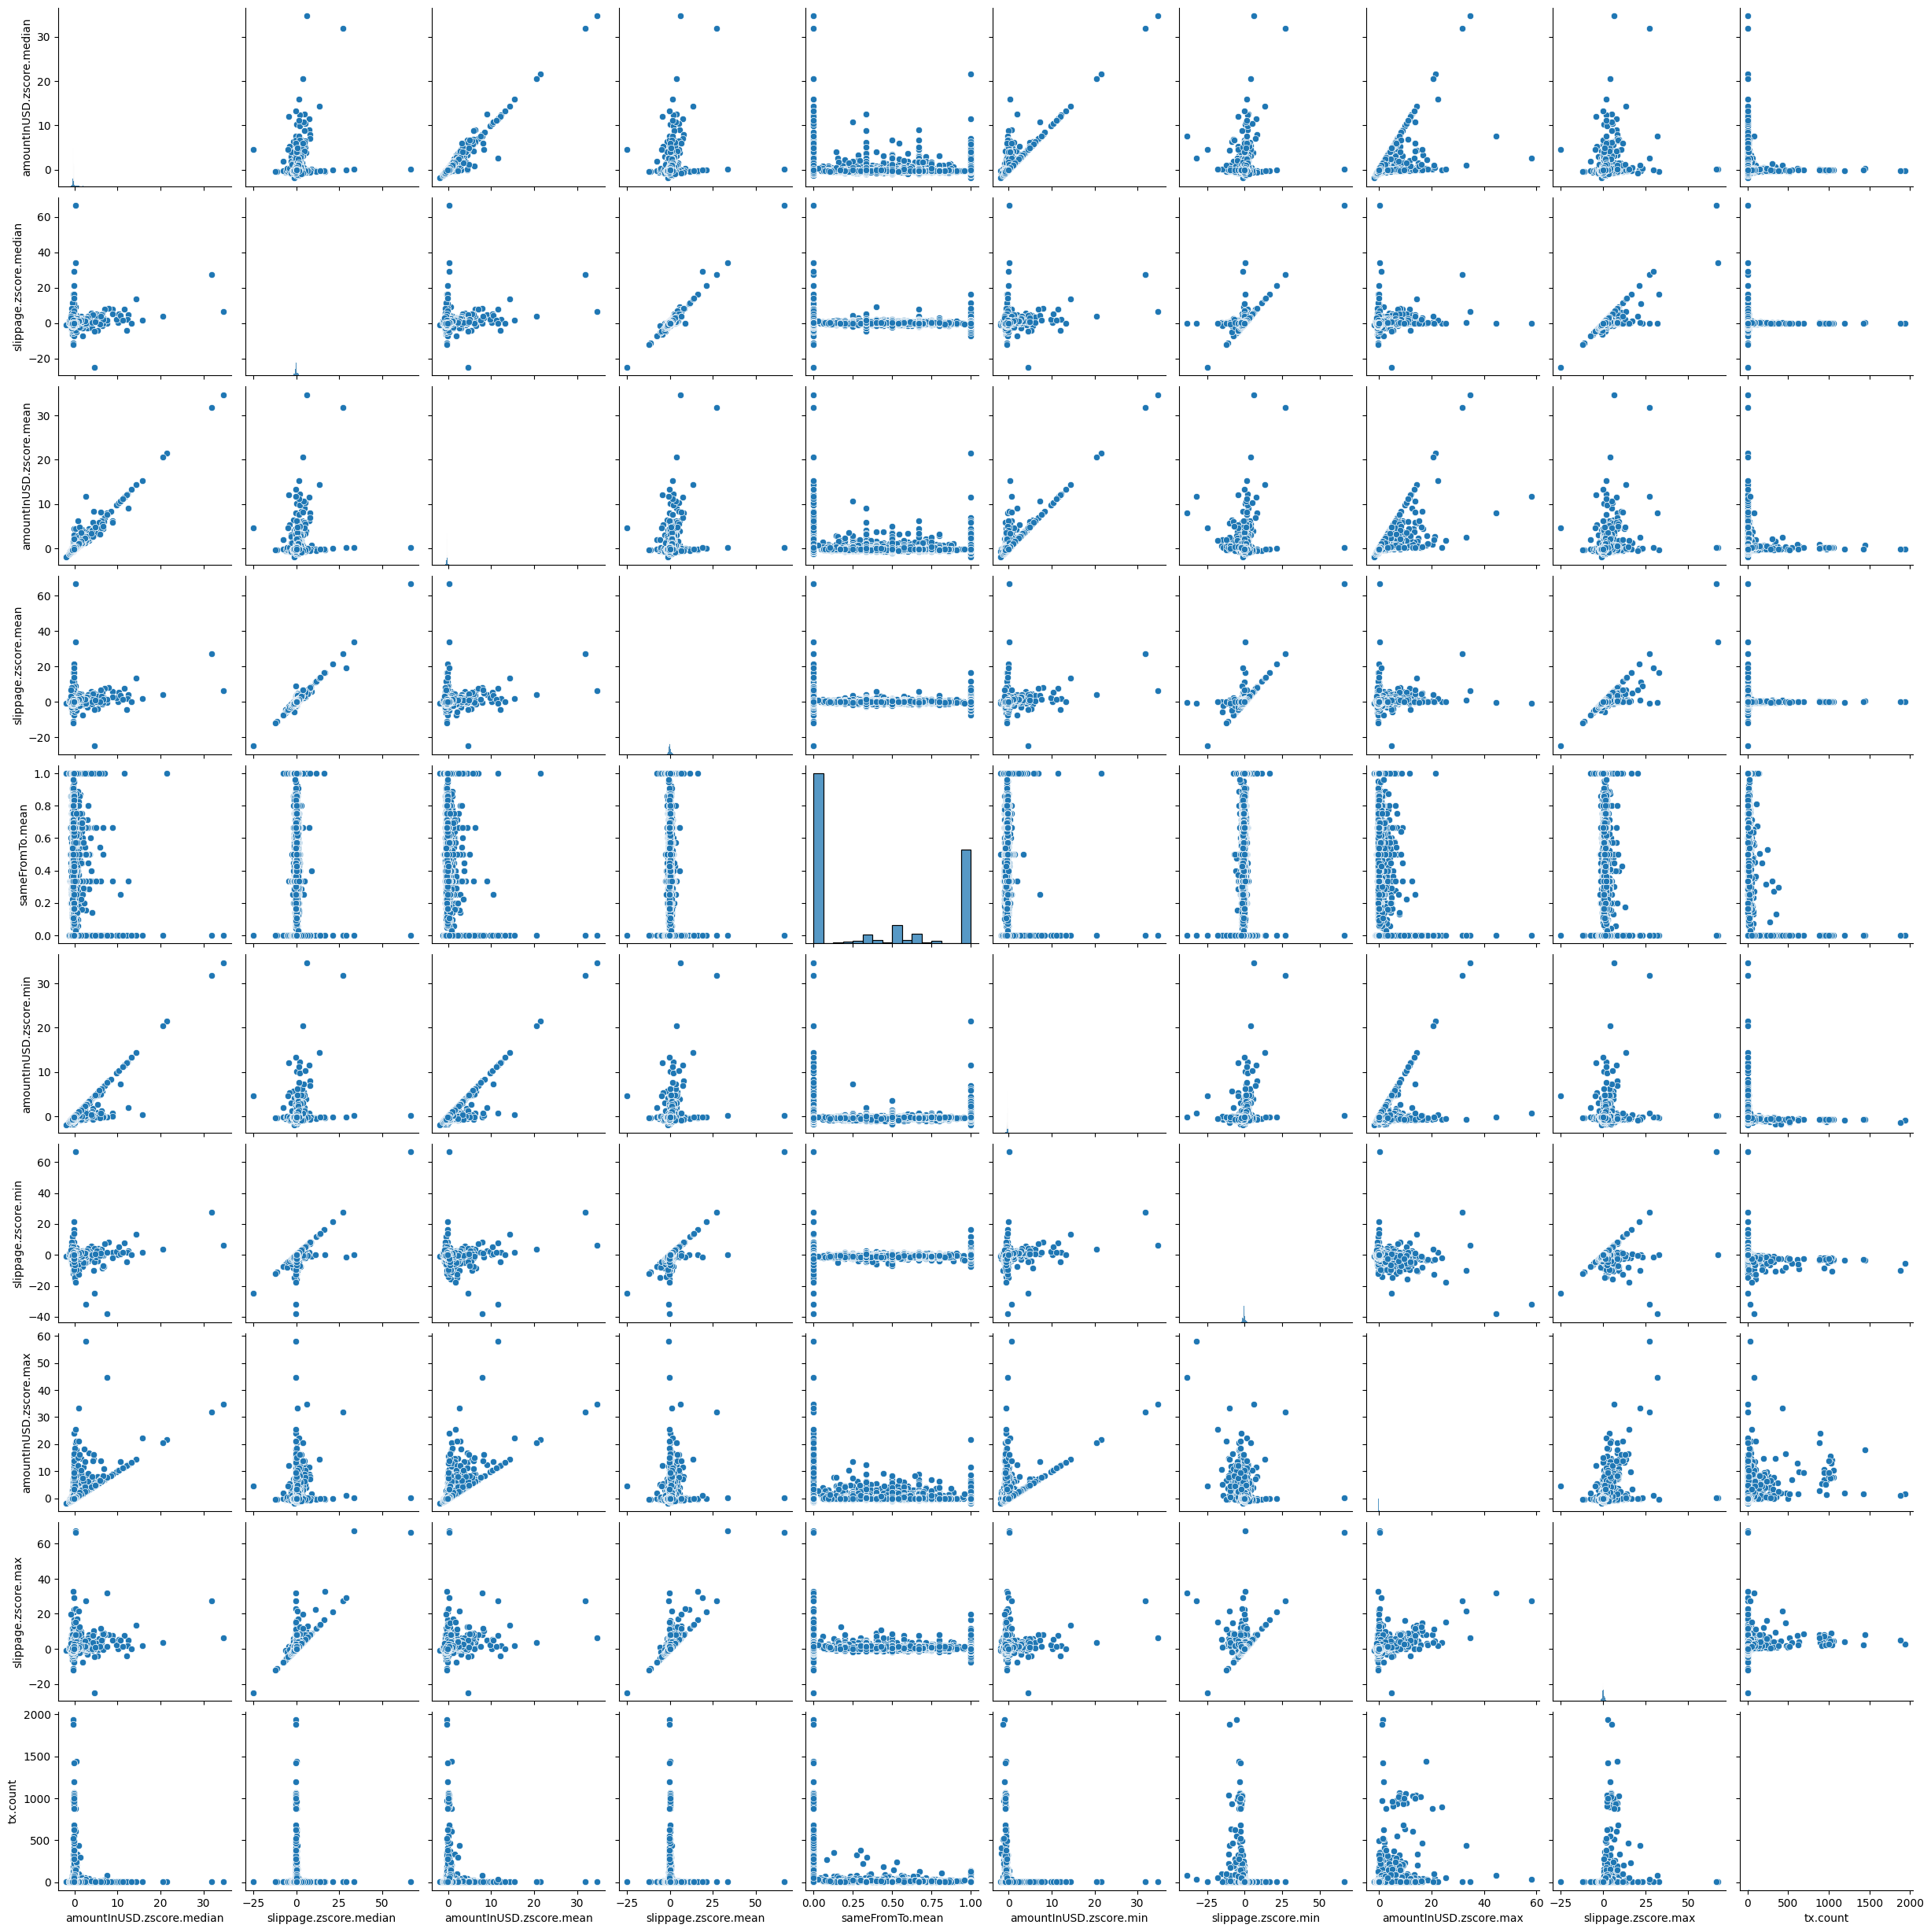

In [68]:
# sns.pairplot(addresses_swaps_features)

In [56]:

addresses_swaps_features.nunique()

amountInUSD.zscore.median    841
slippage.zscore.median       190
amountInUSD.zscore.mean      847
slippage.zscore.mean         237
amountInUSD.zscore.min       811
slippage.zscore.min          151
amountInUSD.zscore.max       847
slippage.zscore.max          152
dtype: int64

## Merging features from swaps, deposits and withdraws

In [9]:
address_features = addresses_swaps_features.join(addresses_deposits_features.join(
    addresses_withdraws_features, lsuffix='.deposits', rsuffix='.withdraws', how='outer'),
    lsuffix='.swaps', how='outer')

In [24]:
from sklearn.preprocessing import StandardScaler
import umap

addresses_swaps_features.dropna(inplace=True)

scaled_swaps = StandardScaler().fit_transform(addresses_swaps_features)

reducer = umap.UMAP(n_neighbors=1000, min_dist=0.5, n_components=2, metric='euclidean')

embedding_swaps = reducer.fit_transform(scaled_swaps)
embedding_swaps.shape

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot: >

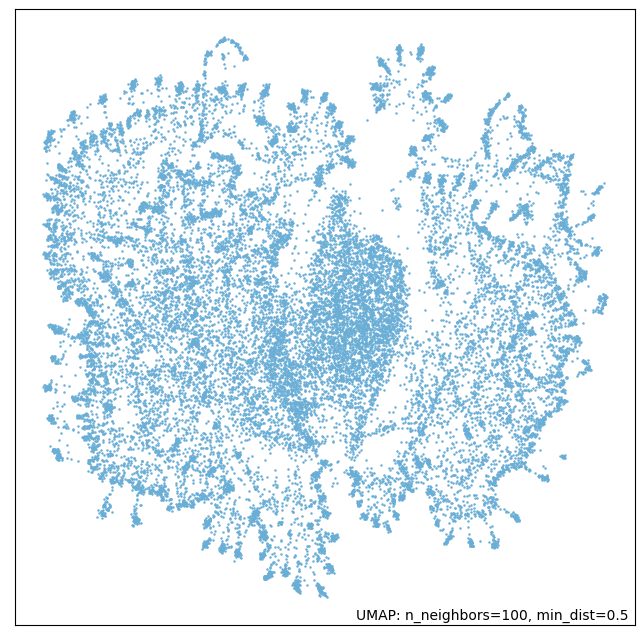

In [ ]:
import umap.plot
umap.plot.points(reducer)



<AxesSubplot: >

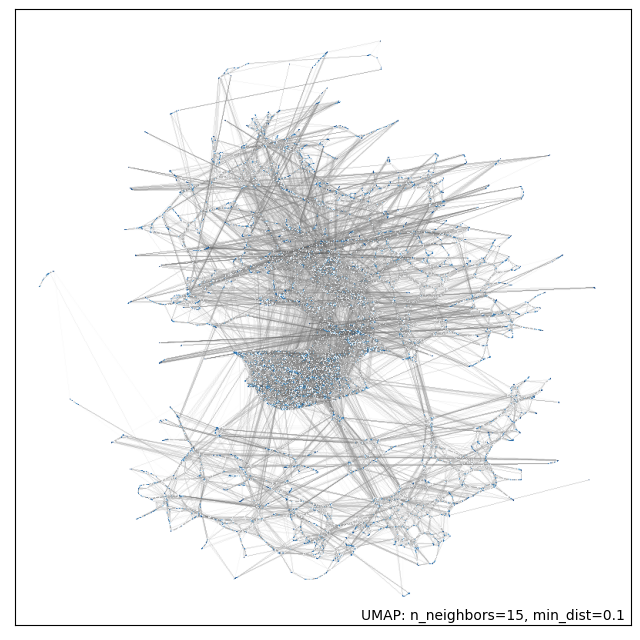

In [19]:
umap.plot.connectivity(reducer, show_points=True)

In [2]:
from web3 import Web3
from web3.beacon import Beacon

w3 = Web3(Web3.HTTPProvider('http://127.0.0.1:8545'))
w3.isConnected()
block = web3.eth.get_block('latest')
block['number']
web3.eth.syncing
beacon = Beacon("http://localhost:5052")
beacon.get_syncing()


/home/fujiju/anaconda3/envs/py0xcluster/lib/python3.8/site-packages/web3/beacon/__init__.py:4: UserWarning: Beacon node APIs are experimental and may not be implemented consistently by all clients.
  warnings.warn(


{'data': {'head_slot': '4463245',
  'sync_distance': '1196817',
  'is_syncing': True,
  'is_optimistic': False}}

In [ ]:
uni3_events.withdraws.to_pickle('/home/fujiju/Documents/GitHub/py0xcluster/data/20230117_215100_withdraws.pkl')

In [ ]:
deposits = pd.read_pickle('/home/fujiju/Documents/GitHub/py0xcluster/data/20230117_215100_deposits.pkl')

In [ ]:
import pickle
filename = '/home/fujiju/Documents/GitHub/py0xcluster/data/20230117_215800_all_events.pkl'
fileh = open(filename, 'w')
pickle.dump(uni3_events, fileh)

In [ ]:
uni3_events['swaps'].nunique()